In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder.appName("App").master("local").getOrCreate()

In [ ]:
file_path = '/content/pubmed25n0901.parquet'
df = spark.read.parquet(file_path)


In [ ]:
df.show(5)

+--------------------+--------------------+
|     MedlineCitation|          PubmedData|
+--------------------+--------------------+
|{"@Status": "MEDL...|{"History": {"Pub...|
|{"@Status": "MEDL...|{"History": {"Pub...|
|{"@Status": "MEDL...|{"History": {"Pub...|
|{"@Status": "MEDL...|{"History": {"Pub...|
|{"@Status": "MEDL...|{"History": {"Pub...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
df.printSchema()

root
 |-- MedlineCitation: string (nullable = true)
 |-- PubmedData: string (nullable = true)



In [ ]:

df.count()

30000

In [ ]:
from pyspark.sql.functions import from_json, struct

json_schema_medline = spark.read.json(df.rdd.map(lambda row: row.MedlineCitation)).schema
json_schema_pubmed = spark.read.json(df.rdd.map(lambda row: row.PubmedData)).schema

df_parsed = df.withColumn("MedlineCitation", from_json("MedlineCitation", json_schema_medline)) \
              .withColumn("PubmedData", from_json("PubmedData", json_schema_pubmed))

df_parsed.printSchema()

root
 |-- MedlineCitation: struct (nullable = true)
 |    |-- @IndexingMethod: string (nullable = true)
 |    |-- @Owner: string (nullable = true)
 |    |-- @Status: string (nullable = true)
 |    |-- @VersionDate: string (nullable = true)
 |    |-- @VersionID: string (nullable = true)
 |    |-- Article: struct (nullable = true)
 |    |    |-- @PubModel: string (nullable = true)
 |    |    |-- Abstract: struct (nullable = true)
 |    |    |    |-- AbstractText: string (nullable = true)
 |    |    |    |-- CopyrightInformation: string (nullable = true)
 |    |    |-- ArticleDate: struct (nullable = true)
 |    |    |    |-- @DateType: string (nullable = true)
 |    |    |    |-- Day: string (nullable = true)
 |    |    |    |-- Month: string (nullable = true)
 |    |    |    |-- Year: string (nullable = true)
 |    |    |-- ArticleTitle: string (nullable = true)
 |    |    |-- AuthorList: struct (nullable = true)
 |    |    |    |-- @CompleteYN: string (nullable = true)
 |    |    |    

In [ ]:
from pyspark.sql.functions import col

missing_values = df_parsed.select([count(when(col(c).isNull(), c)).alias(c) for c in df_parsed.columns])
missing_values.show()

+---------------+----------+
|MedlineCitation|PubmedData|
+---------------+----------+
|              0|         0|
+---------------+----------+



In [ ]:
from pyspark.sql.functions import col

pmid_count = df_parsed.select("MedlineCitation.PMID").count()

print(f"PMID Count: {pmid_count}")


PMID Count: 30000


In [ ]:
df_with_abstract = df_parsed.filter(col("MedlineCitation.Article.Abstract.AbstractText").isNotNull())


df_with_abstract.count()

24938

In [ ]:
df_withcitation = df_with_abstract.filter(df_with_abstract["PubmedData.ReferenceList.Reference"].isNotNull()) \
    .select("PubmedData.ReferenceList.Reference")

In [ ]:
df_withcitation.count()

12027

In [ ]:
df_with_reference_and_abstract = df_with_abstract.filter(df_with_abstract["PubmedData.ReferenceList.Reference"].isNotNull()) \
    .filter(df_with_abstract["MedlineCitation.Article.Abstract.AbstractText"].isNotNull()) \
    .select("MedlineCitation", "PubmedData")

df_with_reference_and_abstract.show(50, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df_with_abstract.count()

24938

## 1.1 EDA for References

In [ ]:
df_with_abstract.printSchema()

root
 |-- MedlineCitation: struct (nullable = true)
 |    |-- @IndexingMethod: string (nullable = true)
 |    |-- @Owner: string (nullable = true)
 |    |-- @Status: string (nullable = true)
 |    |-- @VersionDate: string (nullable = true)
 |    |-- @VersionID: string (nullable = true)
 |    |-- Article: struct (nullable = true)
 |    |    |-- @PubModel: string (nullable = true)
 |    |    |-- Abstract: struct (nullable = true)
 |    |    |    |-- AbstractText: string (nullable = true)
 |    |    |    |-- CopyrightInformation: string (nullable = true)
 |    |    |-- ArticleDate: struct (nullable = true)
 |    |    |    |-- @DateType: string (nullable = true)
 |    |    |    |-- Day: string (nullable = true)
 |    |    |    |-- Month: string (nullable = true)
 |    |    |    |-- Year: string (nullable = true)
 |    |    |-- ArticleTitle: string (nullable = true)
 |    |    |-- AuthorList: struct (nullable = true)
 |    |    |    |-- @CompleteYN: string (nullable = true)
 |    |    |    

In [ ]:
# Count the number of abstracts / articles

df_with_abstract.selectExpr(
    "MedlineCitation.Article.Abstract.AbstractText",
    "PubmedData.ReferenceList"
).summary("count").show()

+-------+------------+
|summary|AbstractText|
+-------+------------+
|  count|       24938|
+-------+------------+



In [ ]:
#### TOTAL NUMBER OF ARTICLES PER YEAR
df_with_abstract.select("MedlineCitation.Article.ArticleDate.Year").groupby("Year").count().show()

+----+-----+
|Year|count|
+----+-----+
|2016| 1365|
|2012|   80|
|2017|16464|
|2014|  237|
|2013|  114|
|NULL| 6123|
|2018|   14|
|2009|    1|
|2011|   63|
|2008|    4|
|2015|  466|
|2010|    7|
+----+-----+



<ipython-input-50-d918e7b71094>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Year", y="count", data=reference_counts, palette="viridis")


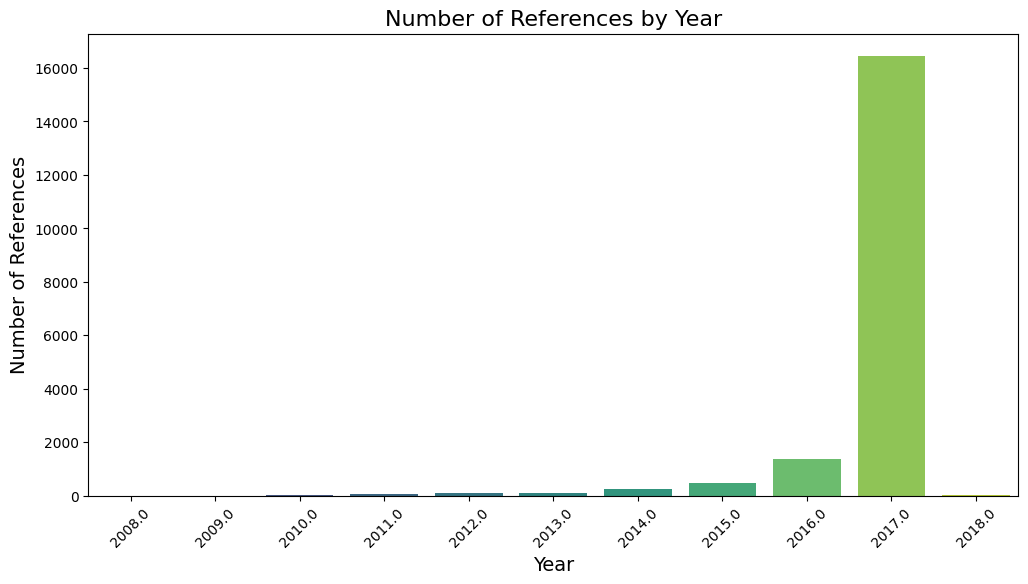

In [ ]:
#### TOTAL NUMBER OF ARTICLES PER YEAR
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


reference_counts = df_with_abstract.select("MedlineCitation.Article.ArticleDate.Year") \
    .groupby("Year") \
    .count() \
    .toPandas()

reference_counts["Year"] = pd.to_numeric(reference_counts["Year"], errors="coerce")


reference_counts = reference_counts.sort_values("Year")

plt.figure(figsize=(12, 6))
sns.barplot(x="Year", y="count", data=reference_counts, palette="viridis")

plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of References", fontsize=14)
plt.title("Number of References by Year", fontsize=16)
plt.xticks(rotation=45)

plt.show()

In [ ]:
from pyspark.sql.functions import from_json, col, size
from pyspark.sql.types import ArrayType, StructType, StructField, StringType

reference_schema = ArrayType(
    StructType([
        StructField("Citation", StringType(), True),
        StructField("ArticleIdList", StructType([
            StructField("ArticleId", StructType([
                StructField("@IdType", StringType(), True),
                StructField("#text", StringType(), True)
            ]), True)
        ]), True)
    ])
)

df_parsed = df_with_reference_and_abstract.withColumn(
    "parsed_references",
    from_json(col("PubmedData.ReferenceList.Reference"), reference_schema)
)

df_parsed = df_parsed.withColumn("num_references", size(col("parsed_references")))

df_parsed.select("num_references").show()

+--------------+
|num_references|
+--------------+
|            37|
|            34|
|            28|
|            49|
|            20|
|            42|
|            55|
|            32|
|            19|
|            95|
|            50|
|            54|
|            21|
|            66|
|            57|
|            33|
|            31|
|            19|
|            56|
|            46|
+--------------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import sum

total_references = df_parsed.select(sum("num_references")).collect()[0][0]

print(f"Total number of references from all articles: {total_references}")

Total number of references from all articles: 455318


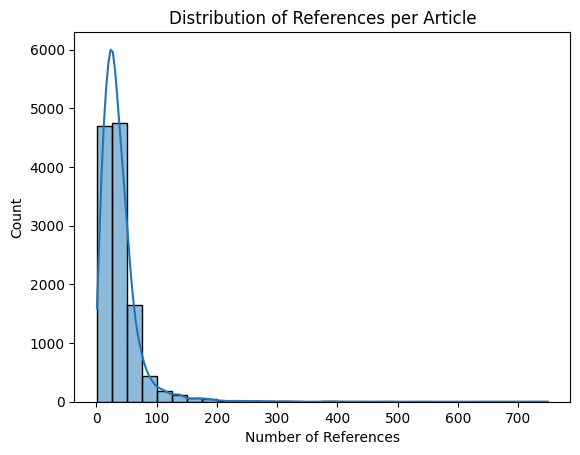

In [ ]:

df_references_pandas = df_parsed.select("num_references").toPandas()

sns.histplot(df_references_pandas["num_references"], bins=30, kde=True)
plt.xlabel("Number of References")
plt.ylabel("Count")
plt.title("Distribution of References per Article")
plt.show()

In [ ]:
#### Seemingly, there are no common themes that decide whether an article is going to be cited more or less. There are religious and political titles that delve into political theory, such as political liberalism and religious claims, and disaster and development studies related to macroeconomic risks. At this point we can suppose that articles concerned with topics of social sciences may be subject to less citation. This is where we could do additional NLP Analysis.
df_parsed.orderBy(col("num_references").desc()).select("MedlineCitation.Article.ArticleTitle", "num_references").show(30)
df_parsed.orderBy(col("num_references").asc()).select("MedlineCitation.Article.ArticleTitle", "num_references").show(30)

+--------------------+--------------+
|        ArticleTitle|num_references|
+--------------------+--------------+
|Acid-Suppressive ...|           749|
|Anticancer Natura...|           542|
|Gaining knowledge...|           488|
|A Comprehensive R...|           482|
|SheddomeDB: the e...|           469|
|{"i":"Acinetobact...|           444|
|A Neurophysiologi...|           430|
|Botulinum Neuroto...|           416|
|Systems Chronothe...|           404|
|New frontiers in ...|           403|
|TGF-β Signaling i...|           390|
|Theranostic Bioma...|           389|
|Precancer Atlas t...|           381|
|Pediatric Obesity...|           375|
|Mechanisms Regula...|           335|
|Natural Compounds...|           333|
|Natural Compounds...|           332|
|Quantitative trai...|           320|
|Alternative splic...|           318|
|Cisplatin-Induced...|           310|
|Composites of Pol...|           309|
|SP and KLF Transc...|           306|
|Pharmacotherapeut...|           294|
|T-lymphocyt

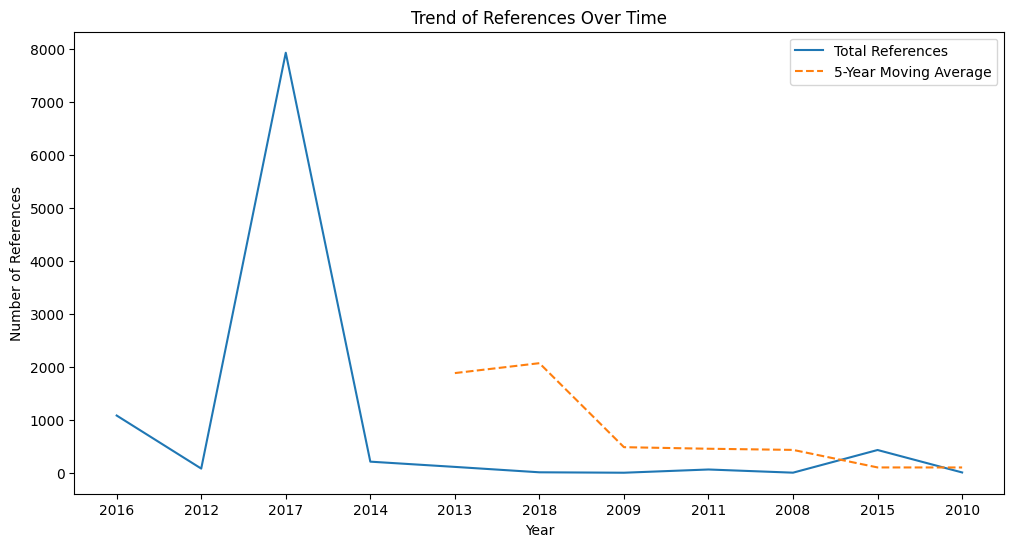

In [ ]:
#### ROLLING AVERAGE OF REFERENCES

from pyspark.sql import functions as F

df_yearly_references = df_parsed.groupBy("MedlineCitation.Article.ArticleDate.Year") \
    .agg(F.count("MedlineCitation.Article.ArticleTitle").alias("total_references"))
df_yearly_references_pandas = df_yearly_references.toPandas()
df_yearly_references_pandas["Rolling_Avg"] = df_yearly_references_pandas["total_references"].rolling(5).mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x="Year", y="total_references", data=df_yearly_references_pandas, label="Total References")
sns.lineplot(x="Year", y="Rolling_Avg", data=df_yearly_references_pandas, label="5-Year Moving Average", linestyle="--")

plt.xlabel("Year")
plt.ylabel("Number of References")
plt.title("Trend of References Over Time")
plt.legend()
plt.show()

## 1.2 EDA for Journals

In [ ]:
df_with_journal = df_with_abstract.select(
    "MedlineCitation.Article.Journal.ISOAbbreviation",
    "MedlineCitation.Article.Journal.Title",
    "MedlineCitation.Article.Journal.ISSN"
)

df_with_journal.show(10)


+-----------------+--------------------+--------------------+
|  ISOAbbreviation|               Title|                ISSN|
+-----------------+--------------------+--------------------+
|   J Chromatogr A|Journal of chroma...|{1873-3778, Elect...|
|   J Chromatogr A|Journal of chroma...|{1873-3778, Elect...|
|   J Chromatogr A|Journal of chroma...|{1873-3778, Elect...|
|     J Emerg Nurs|Journal of emerge...|{1527-2966, Elect...|
|Sci Total Environ|The Science of th...|{1879-1026, Elect...|
|    Gynecol Oncol|Gynecologic oncology|{1095-6859, Elect...|
|          Surgery|             Surgery|{1532-7361, Elect...|
|          Surgery|             Surgery|{1532-7361, Elect...|
|          Surgery|             Surgery|{1532-7361, Elect...|
|  Biol Psychiatry|Biological psychi...|{1873-2402, Elect...|
+-----------------+--------------------+--------------------+
only showing top 10 rows



In [ ]:
from pyspark.sql.functions import col

df_with_journal = df_with_journal.withColumn("ISSN_text", col("ISSN.#text"))
df_with_journal.show(10)

+-----------------+--------------------+--------------------+---------+
|  ISOAbbreviation|               Title|                ISSN|ISSN_text|
+-----------------+--------------------+--------------------+---------+
|   J Chromatogr A|Journal of chroma...|{1873-3778, Elect...|1873-3778|
|   J Chromatogr A|Journal of chroma...|{1873-3778, Elect...|1873-3778|
|   J Chromatogr A|Journal of chroma...|{1873-3778, Elect...|1873-3778|
|     J Emerg Nurs|Journal of emerge...|{1527-2966, Elect...|1527-2966|
|Sci Total Environ|The Science of th...|{1879-1026, Elect...|1879-1026|
|    Gynecol Oncol|Gynecologic oncology|{1095-6859, Elect...|1095-6859|
|          Surgery|             Surgery|{1532-7361, Elect...|1532-7361|
|          Surgery|             Surgery|{1532-7361, Elect...|1532-7361|
|          Surgery|             Surgery|{1532-7361, Elect...|1532-7361|
|  Biol Psychiatry|Biological psychi...|{1873-2402, Elect...|1873-2402|
+-----------------+--------------------+--------------------+---

In [ ]:
df_with_journal.filter(df_with_journal["ISSN_text"].isNull()).show(10)

+--------------------+--------------------+----+---------+
|     ISOAbbreviation|               Title|ISSN|ISSN_text|
+--------------------+--------------------+----+---------+
|Proc ACM Int Conf...|Proceedings of th...|NULL|     NULL|
|Proc Int Conf Web...|Proceedings of th...|NULL|     NULL|
|Proc Int Conf Web...|Proceedings of th...|NULL|     NULL|
|Proc SIGCHI Conf ...|Proceedings of th...|NULL|     NULL|
|   Proc Wirel Health|Proceedings Wirel...|NULL|     NULL|
|Policy Brief UCLA...|Policy brief (UCL...|NULL|     NULL|
|Ann Gerontol Geri...|Annals of geronto...|NULL|     NULL|
|Conf Proc Int Con...|Conference procee...|NULL|     NULL|
|Conf Proc Int Con...|Conference procee...|NULL|     NULL|
|Conf Proc Int Con...|Conference procee...|NULL|     NULL|
+--------------------+--------------------+----+---------+
only showing top 10 rows



In [ ]:
df_with_journal.groupBy("ISSN_text").count().orderBy("count", ascending=False).show(10)

+---------+-----+
|ISSN_text|count|
+---------+-----+
|2045-2322|  613|
|1932-6203|  517|
|2079-4991|  310|
|1300-0667|  253|
|2311-2638|  185|
|2391-5463|  185|
|1923-2829|  168|
|1940-6029|  164|
|1469-1825|  124|
|1423-0380|  113|
+---------+-----+
only showing top 10 rows



In [ ]:
df_with_journal.groupBy("ISOAbbreviation").count().orderBy("count", ascending=False).show(10)

+--------------------+-----+
|     ISOAbbreviation|count|
+--------------------+-----+
|             Sci Rep|  613|
|            PLoS One|  517|
|Nanomaterials (Ba...|  310|
|  Noro Psikiyatr Ars|  253|
|     Open Med (Wars)|  185|
|         Microb Cell|  185|
|         Cardiol Res|  168|
|    Methods Mol Biol|  164|
|     Behav Brain Sci|  124|
|         Tumour Biol|  113|
+--------------------+-----+
only showing top 10 rows



In [ ]:
df_with_journal = df_with_journal.withColumn("IssnType", col("ISSN.@IssnType"))
df_with_journal.groupBy("IssnType").count().show()

+----------+-----+
|  IssnType|count|
+----------+-----+
|      NULL|   11|
|     Print| 5315|
|Electronic|19612|
+----------+-----+



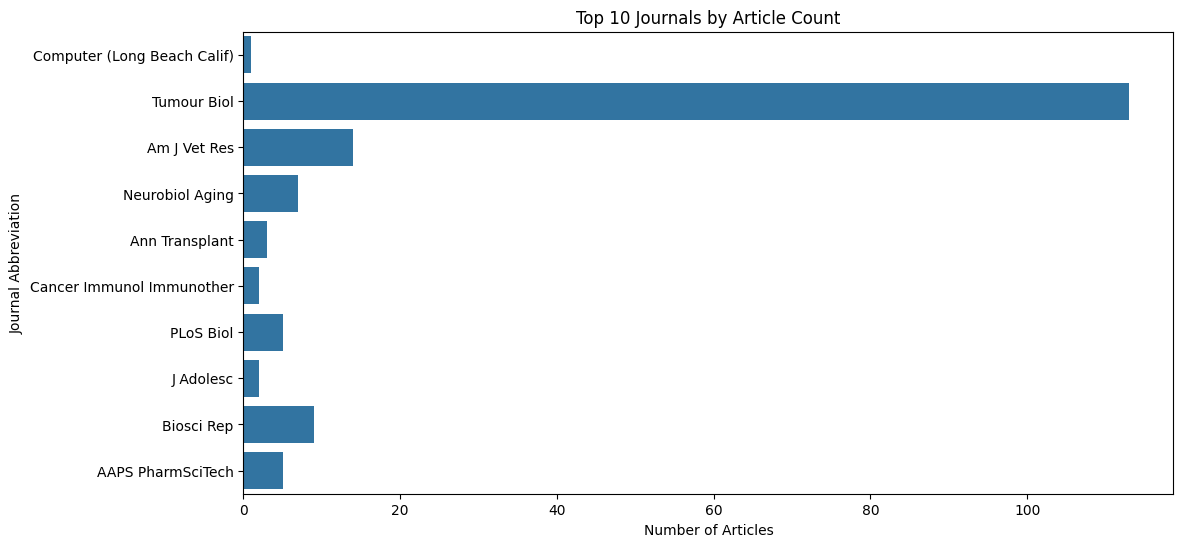

In [ ]:
df_journal_counts = df_with_journal.groupBy("ISOAbbreviation").count().toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="ISOAbbreviation", data=df_journal_counts.head(10))
plt.xlabel("Number of Articles")
plt.ylabel("Journal Abbreviation")
plt.title("Top 10 Journals by Article Count")
plt.show()

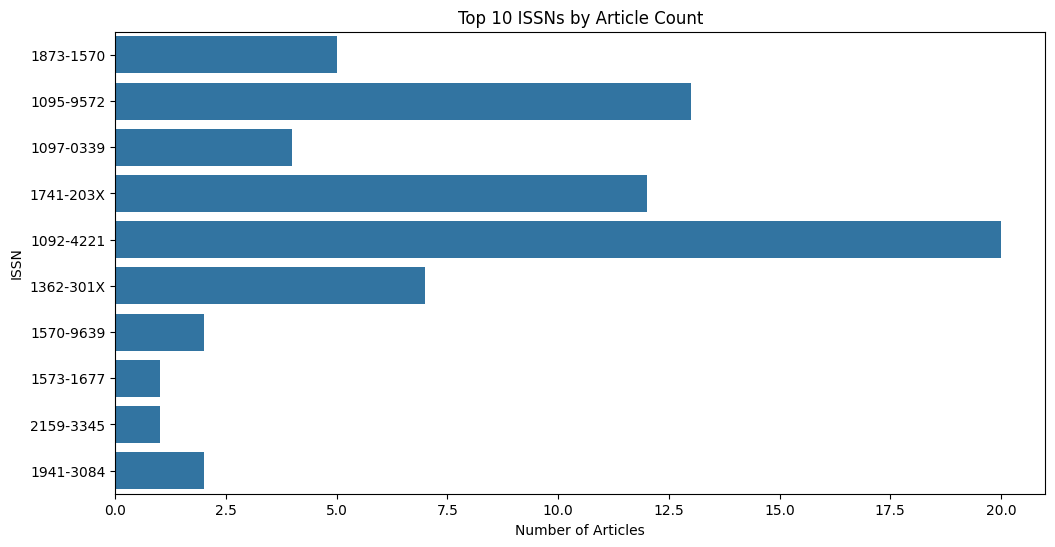

In [ ]:
df_issn_counts = df_with_journal.groupBy("ISSN_text").count().toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="ISSN_text", data=df_issn_counts.head(10))
plt.xlabel("Number of Articles")
plt.ylabel("ISSN")
plt.title("Top 10 ISSNs by Article Count")
plt.show()

## 1.3 EDA for Languages

In [ ]:
df_lng= df_with_abstract.select(
    col("MedlineCitation.Article.Language"))

df_lng.printSchema()

root
 |-- Language: string (nullable = true)



In [ ]:
df_lng_pandas = df_lng.toPandas()
df_lng_pandas.value_counts()

,count
Language,
eng,24524
chi,90
ger,87
fre,74
"[""eng"",""spa""]",45
dut,23
spa,20
"[""por"",""eng""]",18
"[""eng"",""por""]",12


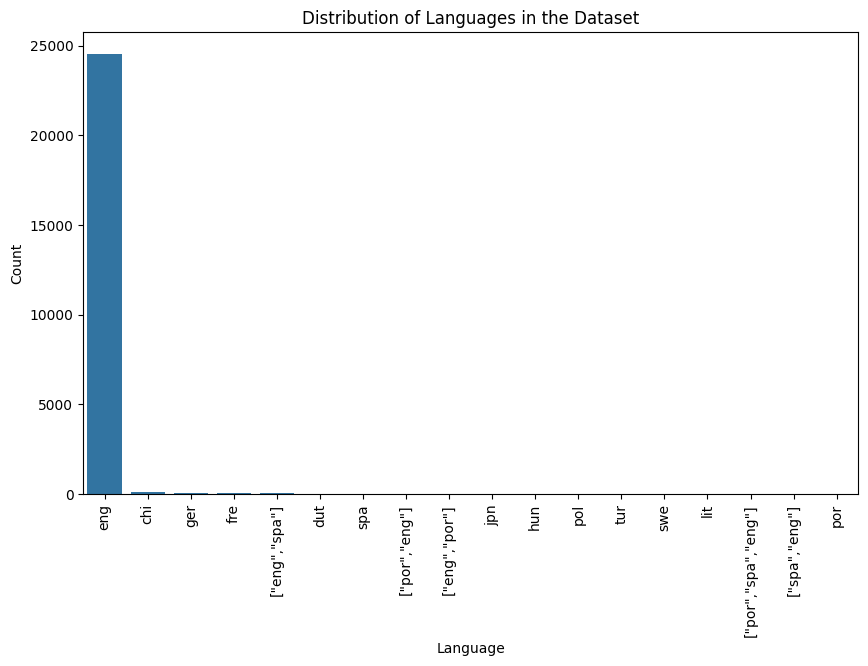

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
language_counts = df_lng_pandas['Language'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=language_counts.index, y=language_counts.values)
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Distribution of Languages in the Dataset')
plt.xticks(rotation=90)
plt.show()

## 1.4 EDA for Grants

In [ ]:
df_grant= df_with_abstract.select(
    col("MedlineCitation.Article.GrantList"))

df_grant.show(10, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|GrantList                                                                                                                                                                                                                                                                              |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|NULL                                                                                                                                                     

In [ ]:
from pyspark.sql.functions import col, explode, from_json, when, array
from pyspark.sql.types import ArrayType, StructType, StructField, StringType

grant_schema = StructType([
    StructField("GrantID", StringType(), True),
    StructField("Acronym", StringType(), True),
    StructField("Agency", StringType(), True),
    StructField("Country", StringType(), True)
])

df_extracted = df_grant.select(
    col("GrantList.@CompleteYN").alias("CompleteYN"),
    col("GrantList.Grant").alias("Grant")
)

df_with_type = df_extracted.withColumn(
    "is_array",
    col("Grant").startswith("[")
)

df_parsed = df_with_type.withColumn(
    "parsed_grants",
    when(
        col("is_array"),
        from_json(col("Grant"), ArrayType(grant_schema))
    ).otherwise(
        array(from_json(col("Grant"), grant_schema))
    )
)

df_exploded = df_parsed.select(
    col("CompleteYN"),
    explode(col("parsed_grants")).alias("grant_details")
)

df_final = df_exploded.select(
    col("CompleteYN"),
    col("grant_details.GrantID").alias("GrantID"),
    col("grant_details.Acronym").alias("Acronym"),
    col("grant_details.Agency").alias("Agency"),
    col("grant_details.Country").alias("Country")
)

df_final.show(truncate=False)

+----------+-----------------+-------+------------------------+--------------+
|CompleteYN|GrantID          |Acronym|Agency                  |Country       |
+----------+-----------------+-------+------------------------+--------------+
|NULL      |NULL             |NULL   |NULL                    |NULL          |
|NULL      |NULL             |NULL   |NULL                    |NULL          |
|NULL      |NULL             |NULL   |NULL                    |NULL          |
|NULL      |NULL             |NULL   |NULL                    |NULL          |
|NULL      |NULL             |NULL   |NULL                    |NULL          |
|Y         |R01 CA169121     |CA     |NCI NIH HHS             |United States |
|Y         |R01 CA166084     |CA     |NCI NIH HHS             |United States |
|Y         |R35 CA197730     |CA     |NCI NIH HHS             |United States |
|Y         |R01 HL105453     |HL     |NHLBI NIH HHS           |United States |
|Y         |T32 HL007734     |HL     |NHLBI NIH HHS 

In [ ]:

country_counts = df_final.groupBy("Country").count().orderBy(col("count").desc())
agency_counts = df_final.groupBy("Agency").count().orderBy(col("count").desc())
print("Grant counts by Country:")
country_counts.show(truncate=False)
agency_country_counts = df_final.groupBy("Agency", "Country").count().orderBy(col("count").desc())

print("Grant counts by Agency (with Country):")
agency_country_counts.show(truncate=False)

Grant counts by Country:
+--------------+-----+
|Country       |count|
+--------------+-----+
|NULL          |21628|
|United States |7857 |
|United Kingdom|1345 |
|International |231  |
|Canada        |122  |
|Austria       |60   |
|Switzerland   |4    |
|Italy         |3    |
|India         |2    |
|Ireland       |1    |
+--------------+-----+

Grant counts by Agency (with Country):
+------------------------------------------------------+--------------+-----+
|Agency                                                |Country       |count|
+------------------------------------------------------+--------------+-----+
|NULL                                                  |NULL          |21367|
|NCI NIH HHS                                           |United States |1056 |
|NHLBI NIH HHS                                         |United States |785  |
|NIGMS NIH HHS                                         |United States |720  |
|NIAID NIH HHS                                         |United Stat

<ipython-input-70-6ebda6e12216>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="Country", data=country_counts_pd, palette="viridis")


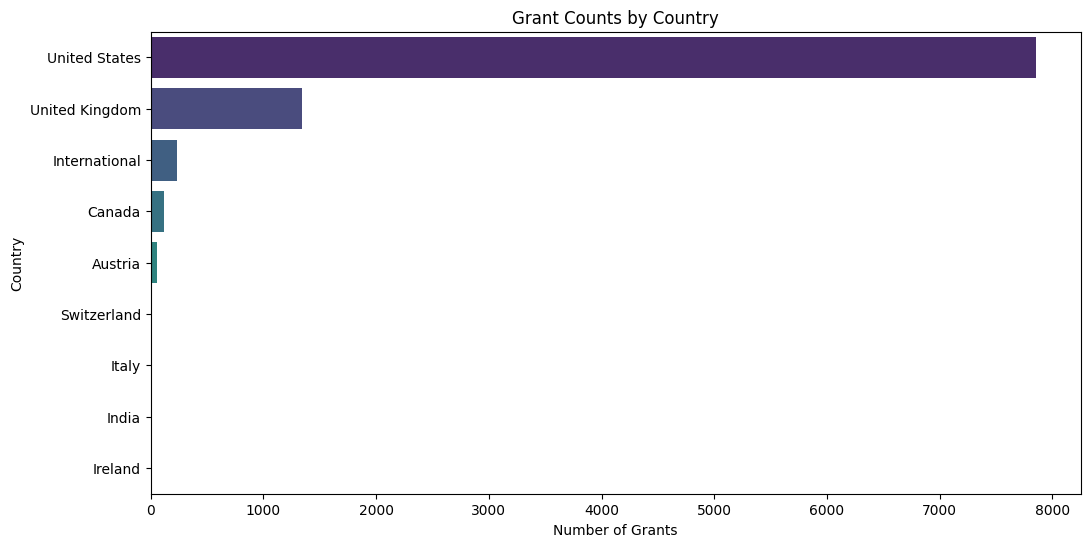

<ipython-input-70-6ebda6e12216>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="Agency", data=top_agencies_pd, palette="magma")


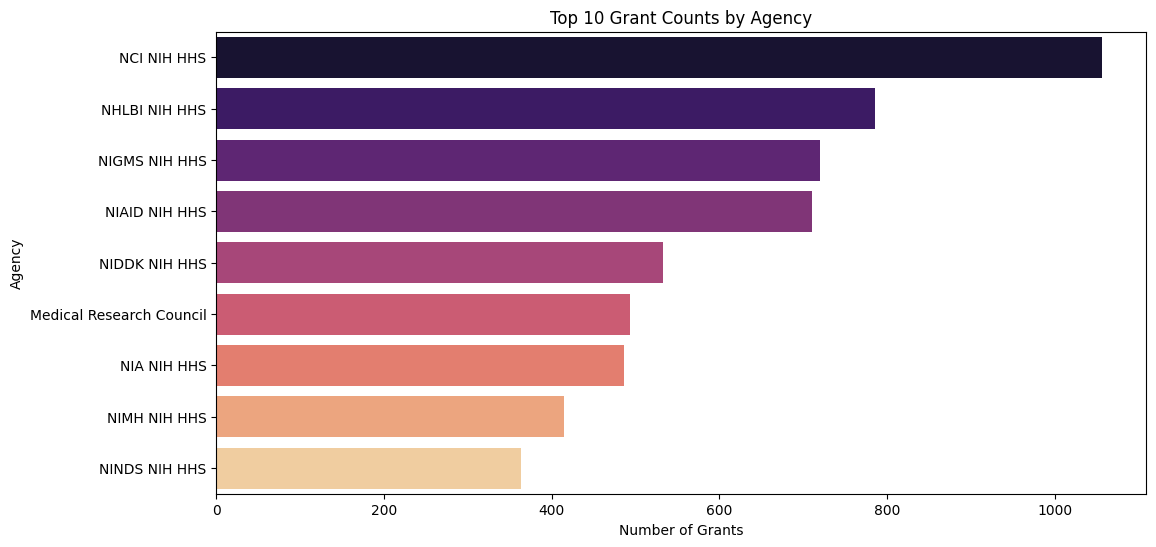

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

country_counts_pd = country_counts.toPandas()
agency_country_counts_pd = agency_country_counts.toPandas()


plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="Country", data=country_counts_pd, palette="viridis")
plt.title("Grant Counts by Country")
plt.xlabel("Number of Grants")
plt.ylabel("Country")
plt.show()

top_n = 10
top_agencies = agency_counts.limit(top_n)
top_agencies_pd = top_agencies.toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="Agency", data=top_agencies_pd, palette="magma")
plt.title(f"Top {top_n} Grant Counts by Agency")
plt.xlabel("Number of Grants")
plt.ylabel("Agency")
plt.show()


In [ ]:
df_curated = df_with_abstract.filter(col("MedlineCitation.@IndexingMethod") == "Curated")

curated_count = df_curated.count()

print(f"Number of curated articles: {curated_count}")

Number of curated articles: 3372


In [ ]:
df_manual = df_with_abstract.filter(col("MedlineCitation.@IndexingMethod") == "Manual")

count_manual = df_manual.count()

print(f"Number of manual articles: {count_manual}")

Number of manual articles: 14988


In [ ]:
df_ind= df_with_abstract.select(
    col("MedlineCitation.@IndexingMethod"))

df_ind.show(100)

+---------------+
|@IndexingMethod|
+---------------+
|        Curated|
|        Curated|
|        Curated|
|         Manual|
|        Curated|
|         Manual|
|         Manual|
|         Manual|
|         Manual|
|         Manual|
|         Manual|
|         Manual|
|         Manual|
|         Manual|
|         Manual|
|         Manual|
|           NULL|
|           NULL|
|         Manual|
|         Manual|
|        Curated|
|        Curated|
|        Curated|
|         Manual|
|         Manual|
|         Manual|
|        Curated|
|         Manual|
|         Manual|
|           NULL|
|         Manual|
|         Manual|
|         Manual|
|         Manual|
|         Manual|
|         Manual|
|         Manual|
|         Manual|
|         Manual|
|         Manual|
|         Manual|
|         Manual|
|         Manual|
|        Curated|
|         Manual|
|         Manual|
|         Manual|
|         Manual|
|         Manual|
|         Manual|
|        Curated|
|         Manual|
|         

In [ ]:
df_status= df_with_abstract.select(
    col("MedlineCitation.@Status"))

df_status.show(100)

+------------------+
|           @Status|
+------------------+
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|PubMed-not-MEDLINE|
|PubMed-not-MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|PubMed-not-MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           MEDLINE|
|           M

In [ ]:
df_cits= df_with_abstract.select(
    col("MedlineCitation.CitationSubset"))

df_cits.show()

+--------------+
|CitationSubset|
+--------------+
|            IM|
|            IM|
|            IM|
|          NULL|
|            IM|
|            IM|
|            IM|
|            IM|
|            IM|
|            IM|
|            IM|
|            IM|
|            IM|
|            IM|
|            IM|
|            IM|
|          NULL|
|          NULL|
|            IM|
|            IM|
+--------------+
only showing top 20 rows



In [ ]:
df_com= df_with_abstract.select(
    col("MedlineCitation.CommentsCorrectionsList"))

df_com.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|CommentsCorrectionsList                                                                                                                                           |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|NULL                                                                                                                                                              |
|NULL                                                                                                                                                              |
|NULL                                                                                                                                                              |
|NULL     

In [ ]:
df_com= df_with_abstract.select(
    col("MedlineCitation.Article.ArticleDate.Year"))

df_com.show(truncate=False)

+----+
|Year|
+----+
|2017|
|2017|
|2017|
|2017|
|2017|
|2017|
|2017|
|2017|
|2017|
|2017|
|NULL|
|NULL|
|NULL|
|2017|
|2017|
|2017|
|2017|
|2017|
|2017|
|2016|
+----+
only showing top 20 rows



In [ ]:
# finalschema


# df_selected = df_with_abstract

df_selected = df_with_reference_and_abstract.select(
    col("MedlineCitation.PMID.#text").alias("PMID"),
    col("MedlineCitation.Article.ArticleTitle").alias("Title"),
    col("MedlineCitation.Article.Abstract.AbstractText").alias("Abstract"),
    col("MedlineCitation.Article.ArticleDate.Year").alias("Year"),
    col("MedlineCitation.Article.AuthorList.Author").alias("Authors"),
    col("MedlineCitation.Article.Journal.Title").alias("Journal"),
    col("MedlineCitation.Article.Language").alias("Language"),
    col("MedlineCitation.Article.PublicationTypeList.PublicationType").alias("PublicationType"),
    col("MedlineCitation.ChemicalList.Chemical").alias("Chemicals"),
    col("MedlineCitation.KeywordList.Keyword").alias("Keywords"),
    col("MedlineCitation.MeshHeadingList.MeshHeading").alias("MeshHeadings"),
    col("PubmedData.ReferenceList.Reference").alias("References")
)
df_selected.show(truncate=False)

+--------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# finalschema

df_finalschema = df_with_abstract.select(
    col("MedlineCitation.PMID.#text").alias("PMID"),
    col("MedlineCitation.Article.ArticleTitle").alias("Title"),
    col("MedlineCitation.Article.Abstract.AbstractText").alias("Abstract"),
    col("MedlineCitation.Article.ArticleDate.Year").alias("Year"),
    col("MedlineCitation.Article.AuthorList.Author").alias("Authors"),
    col("MedlineCitation.Article.Journal.Title").alias("Journal"),
    col("MedlineCitation.Article.Language").alias("Language"),
    col("MedlineCitation.Article.PublicationTypeList.PublicationType").alias("PublicationType"),
    col("MedlineCitation.ChemicalList.Chemical").alias("Chemicals"),
    col("MedlineCitation.KeywordList.Keyword").alias("Keywords"),
    col("MedlineCitation.MeshHeadingList.MeshHeading").alias("MeshHeadings"),
    col("PubmedData.ReferenceList.Reference").alias("References")
)

In [ ]:
from pyspark.sql.functions import length

df_with_lengths = df_finalschema.withColumn("Abstract_Length", length(col("Abstract")))


In [ ]:
abstract_lengths_pd = df_with_lengths.select("Abstract_Length").toPandas()


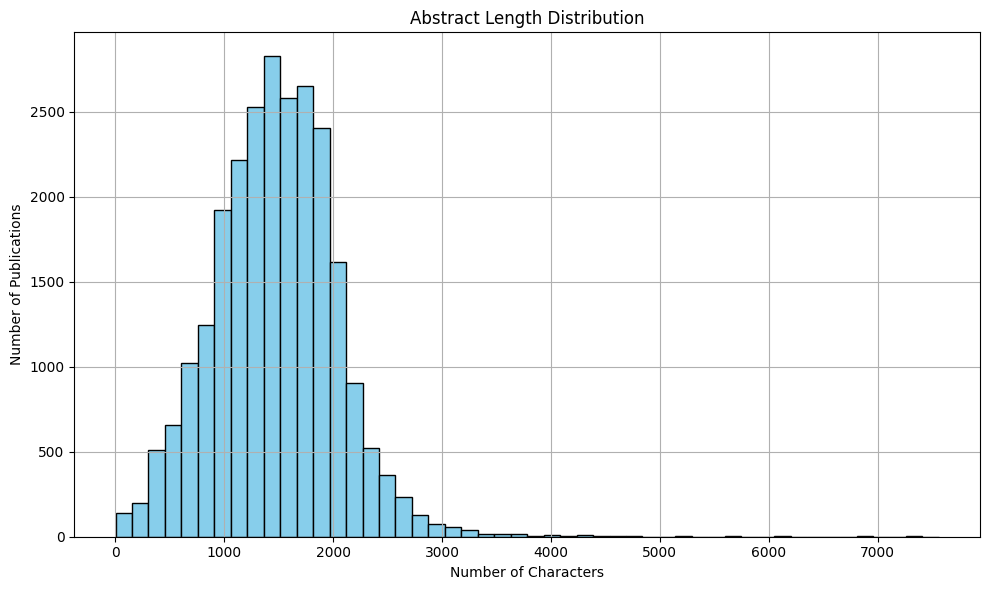

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(abstract_lengths_pd["Abstract_Length"], bins=50, color='skyblue', edgecolor='black')
plt.title("Abstract Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Number of Publications")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-83-528d0833f1d6>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Chemical_Name", data=top_chemicals, palette="viridis")


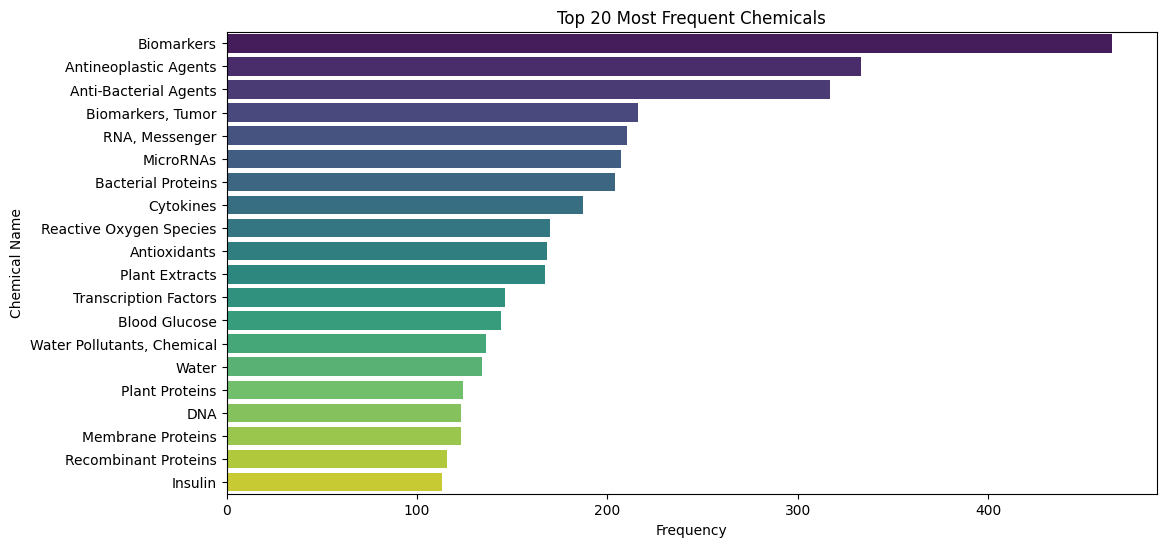

In [ ]:
from pyspark.sql.functions import explode, col, from_json, split, desc, count
from pyspark.sql.types import ArrayType, StructType, StructField, StringType
import matplotlib.pyplot as plt
import seaborn as sns

chemical_schema = ArrayType(
    StructType([
        StructField("NameOfSubstance", StructType([
            StructField("#text", StringType(), True)
        ]), True)
    ])
)

df_chemicals_parsed = df_finalschema.withColumn(
    "Chemicals",
    from_json(col("Chemicals"), chemical_schema)
)

df_exploded_chemicals = df_chemicals_parsed.withColumn(
    "Chemical", explode(col("Chemicals"))
)

df_chemical_names = df_exploded_chemicals.select(
    col("Chemical.NameOfSubstance.#text").alias("Chemical_Name")
).filter(col("Chemical_Name").isNotNull())

top_chemicals = df_chemical_names.groupBy("Chemical_Name").agg(count("*").alias("Frequency")) \
    .orderBy(desc("Frequency")).limit(20).toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x="Frequency", y="Chemical_Name", data=top_chemicals, palette="viridis")
plt.title("Top 20 Most Frequent Chemicals")
plt.xlabel("Frequency")
plt.ylabel("Chemical Name")
plt.show()

<ipython-input-84-2e3357661840>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Keyword", data=top_keywords, palette="viridis")


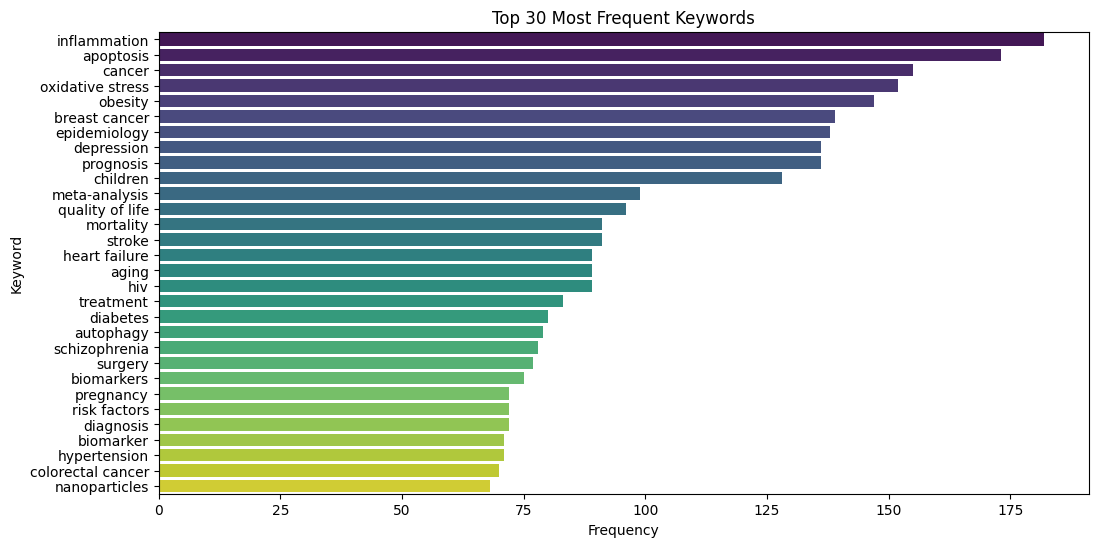

In [ ]:
from pyspark.sql.functions import explode, col, lower, desc, count, from_json, split
from pyspark.sql.types import ArrayType, StructType, StructField, StringType
import matplotlib.pyplot as plt
import seaborn as sns

keyword_schema = ArrayType(
    StructType([
        StructField("@MajorTopicYN", StringType(), True),
        StructField("#text", StringType(), True)
    ])
)

df_keywords_parsed = df_finalschema.withColumn(
    "Keywords",
    from_json(col("Keywords"), keyword_schema)
)

df_exploded_keywords = df_keywords_parsed.withColumn(
    "Keyword", explode(col("Keywords")))

df_keyword_names = df_exploded_keywords.select(
    lower(col("Keyword.#text")).alias("Keyword")
).filter(col("Keyword").isNotNull())

top_keywords = df_keyword_names.groupBy("Keyword").agg(count("*").alias("Frequency")) \
    .orderBy(desc("Frequency")).limit(30).toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x="Frequency", y="Keyword", data=top_keywords, palette="viridis")
plt.title("Top 30 Most Frequent Keywords")
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.show()

<ipython-input-85-1ab5b6477cba>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="MeshHeading", data=top_meshheadings, palette="viridis")


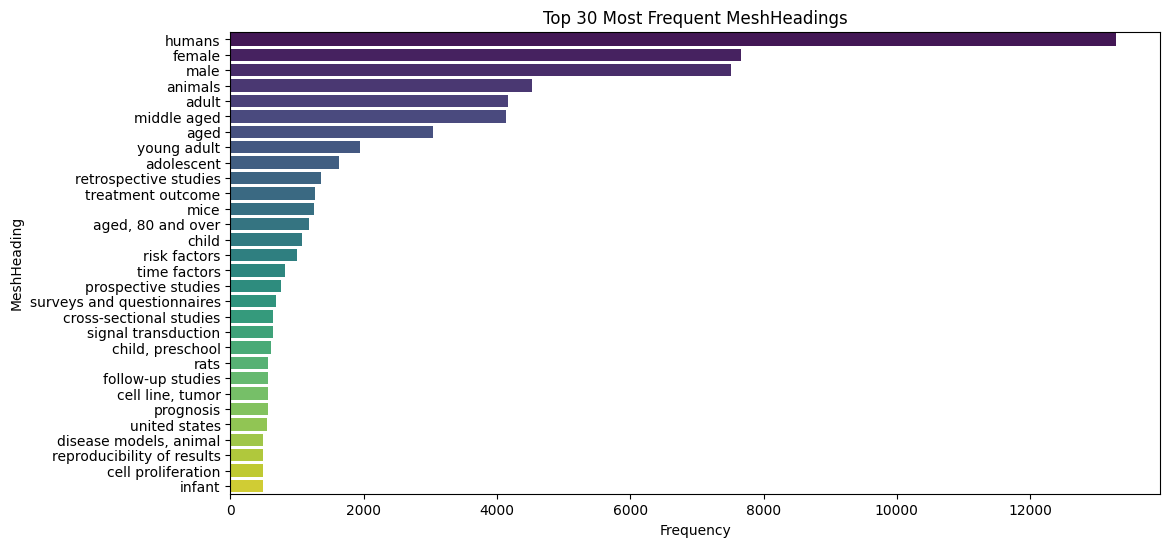

In [ ]:
from pyspark.sql.functions import explode, col, lower, desc, count, from_json
from pyspark.sql.types import ArrayType, StructType, StructField, StringType
import matplotlib.pyplot as plt
import seaborn as sns

meshheading_schema = ArrayType(
    StructType([
        StructField("DescriptorName", StructType([
            StructField("@UI", StringType(), True),
            StructField("@MajorTopicYN", StringType(), True),
            StructField("#text", StringType(), True)
        ]), True),
        StructField("QualifierName", StructType([
            StructField("@UI", StringType(), True),
            StructField("@MajorTopicYN", StringType(), True),
            StructField("#text", StringType(), True)
        ]), True)
    ])
)

df_meshheadings_parsed = df_finalschema.withColumn(
    "MeshHeadings",
    from_json(col("MeshHeadings"), meshheading_schema)
)

df_exploded_meshheadings = df_meshheadings_parsed.withColumn(
    "MeshHeading", explode(col("MeshHeadings"))
).select(
    lower(col("MeshHeading.DescriptorName.#text")).alias("MeshHeading")
).filter(col("MeshHeading").isNotNull())

top_meshheadings = df_exploded_meshheadings.groupBy("MeshHeading").agg(count("*").alias("Frequency")) \
    .orderBy(desc("Frequency")).limit(30).toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x="Frequency", y="MeshHeading", data=top_meshheadings, palette="viridis")
plt.title("Top 30 Most Frequent MeshHeadings")
plt.xlabel("Frequency")
plt.ylabel("MeshHeading")
plt.show()

In [ ]:
df_with_abstract.count()

24938

In [ ]:
df_with_abstract.write.parquet("cleaned_pubmed.parquet")

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/content/cleaned_pubmed.parquet already exists. Set mode as "overwrite" to overwrite the existing path.

In [ ]:
df_with_abstract.write.mode("overwrite").parquet("cleaned_pubmed_tmp")

<ipython-input-87-277c2896b12d>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="Title", data=top_journals, palette="viridis")


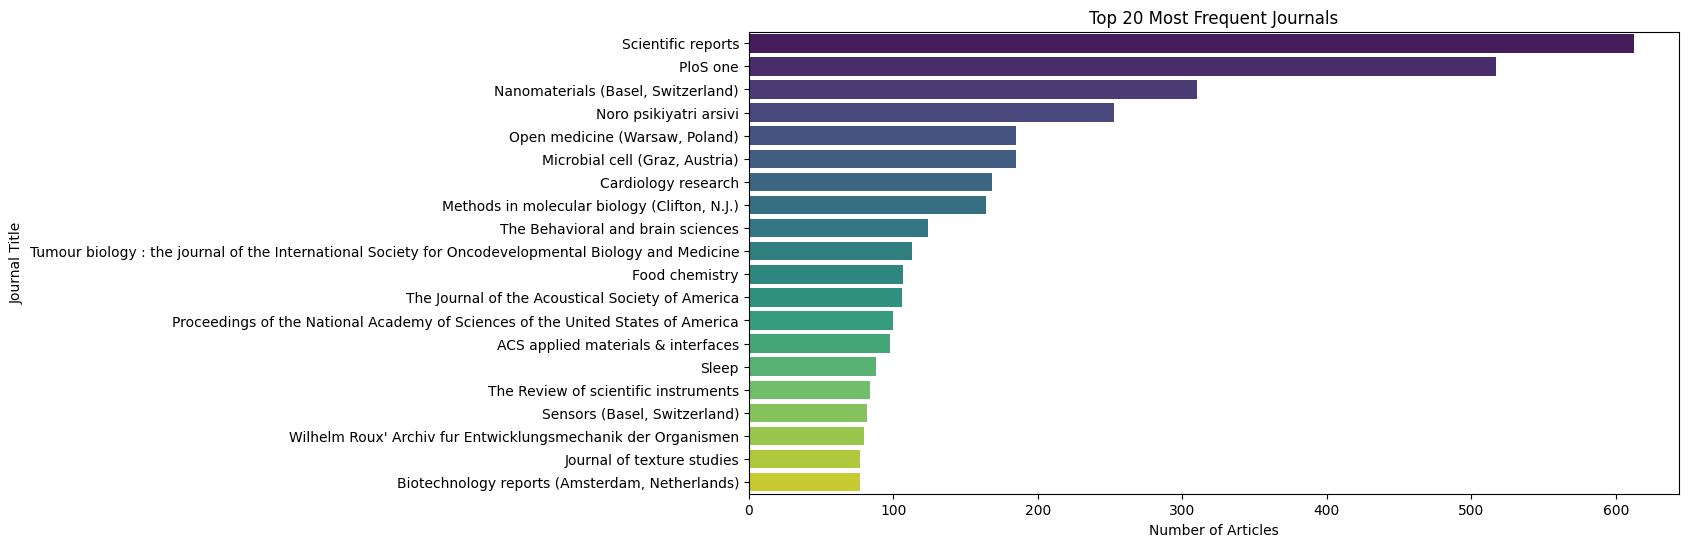

In [ ]:
from pyspark.sql.functions import col, desc

journal_counts = df_with_abstract.groupBy("MedlineCitation.Article.Journal.Title") \
    .count() \
    .orderBy(desc("count"))

top_n = 20
top_journals = journal_counts.limit(top_n).toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="Title", data=top_journals, palette="viridis")
plt.title("Top {} Most Frequent Journals".format(top_n))
plt.xlabel("Number of Articles")
plt.ylabel("Journal Title")

plt.show()

In [ ]:
df_selected.count()

12027

In [ ]:
!pip install --upgrade requests
!pip install --upgrade certifi

In [ ]:
# This script sends a request to the PubMed API to retrieve the number of articles
# that have cited a specific article using its PMID.
import requests


url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?dbfrom=pubmed&linkname=pubmed_pubmed_citedin&id=28343694"
response = requests.get(url)

if response.status_code == 200:

    print(response.text)


    if "<Count>" in response.text:
        count = response.text.split("<Count>")[1].split("</Count>")[0]
        print(int(count))
    else:
        print(0)
    print(f"Error: {response.status_code}")
    print(0)

<?xml version="1.0" encoding="UTF-8" ?>
<!DOCTYPE eLinkResult PUBLIC "-//NLM//DTD elink 20101123//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20101123/elink.dtd">
<eLinkResult>

  <LinkSet>
    <DbFrom>pubmed</DbFrom>
    <IdList>
      <Id>28343694</Id>
    </IdList>
    <LinkSetDb>
      <DbTo>pubmed</DbTo>
      <LinkName>pubmed_pubmed_citedin</LinkName>
      
        <Link>
				<Id>35803464</Id>
			</Link>
        <Link>
				<Id>31727313</Id>
			</Link>
        <Link>
				<Id>31248759</Id>
			</Link>
      
    </LinkSetDb>
  </LinkSet>
</eLinkResult>

0
Error: 200
0


In [ ]:
import requests


url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?dbfrom=pubmed&linkname=pubmed_pubmed_citedin&id=31727313"
response = requests.get(url)

if response.status_code == 200:

    print(response.text)


    if "<Count>" in response.text:
        count = response.text.split("<Count>")[1].split("</Count>")[0]
        print(int(count))
    else:
        print(0)
    print(f"Error: {response.status_code}")
    print(0)

<?xml version="1.0" encoding="UTF-8" ?>
<!DOCTYPE eLinkResult PUBLIC "-//NLM//DTD elink 20101123//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20101123/elink.dtd">
<eLinkResult>

  <LinkSet>
    <DbFrom>pubmed</DbFrom>
    <IdList>
      <Id>31727313</Id>
    </IdList>
    <LinkSetDb>
      <DbTo>pubmed</DbTo>
      <LinkName>pubmed_pubmed_citedin</LinkName>
      
        <Link>
				<Id>35743853</Id>
			</Link>
        <Link>
				<Id>35566745</Id>
			</Link>
        <Link>
				<Id>35053032</Id>
			</Link>
        <Link>
				<Id>34830692</Id>
			</Link>
        <Link>
				<Id>34572424</Id>
			</Link>
        <Link>
				<Id>33807721</Id>
			</Link>
        <Link>
				<Id>33526720</Id>
			</Link>
        <Link>
				<Id>33050747</Id>
			</Link>
        <Link>
				<Id>32778122</Id>
			</Link>
        <Link>
				<Id>32470524</Id>
			</Link>
        <Link>
				<Id>32398452</Id>
			</Link>
      
    </LinkSetDb>
  </LinkSet>
</eLinkResult>

0
Error: 200
0


In [ ]:
import requests


url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?dbfrom=pubmed&linkname=pubmed_pubmed_citedin&id=28343808"
response = requests.get(url)

if response.status_code == 200:

    print(response.text)


    if "<Count>" in response.text:
        count = response.text.split("<Count>")[1].split("</Count>")[0]
        print(int(count))
    else:
        print(0)
    print(f"Error: {response.status_code}")
    print(0)

<?xml version="1.0" encoding="UTF-8" ?>
<!DOCTYPE eLinkResult PUBLIC "-//NLM//DTD elink 20101123//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20101123/elink.dtd">
<eLinkResult>

  <LinkSet>
    <DbFrom>pubmed</DbFrom>
    <IdList>
      <Id>28343808</Id>
    </IdList>
    <LinkSetDb>
      <DbTo>pubmed</DbTo>
      <LinkName>pubmed_pubmed_citedin</LinkName>
      
        <Link>
				<Id>30863912</Id>
			</Link>
        <Link>
				<Id>30069651</Id>
			</Link>
      
    </LinkSetDb>
  </LinkSet>
</eLinkResult>

0
Error: 200
0


In [ ]:
!pip install requests-cache==0.9.7
import requests_cache
requests_cache.install_cache('pubmed_cache')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.9 MB/s eta 0:00:00


In [ ]:
# This file path points to a CSV file where citation data has been stored.
# The CSV was generated by running an automated citation retrieval process
# using the PubMed E-utilities API for all PMIDs in the corresponding Parquet file (901 records).
file_path_cited_by = '/content/drive/MyDrive/PubMedData/pmid_citations_901.csv'
remain_file_path_cited_by = '/content/drive/MyDrive/df_with_abstract.parquet/remaining_pmid_citations.csv'

In [ ]:
df1 = spark.read.format("csv").option("header", "true").load(file_path_cited_by)
df2 = spark.read.format("csv").option("header", "true").load(remain_file_path_cited_by)

AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/content/drive/MyDrive/PubMedData/pmid_citations_901.csv.

In [ ]:
combined_df_with_citedby = df1.union(df2)

In [ ]:
combined_df_with_citedby.show()

In [ ]:
combined_df_with_citedby.count()

In [ ]:
df_finalschema.count()

In [ ]:
df_selected=df_finalschema

In [ ]:
schema = ArrayType(StringType())

df_citedby = combined_df_with_citedby.withColumn("CitedBy", from_json(col("CitedBy"), schema))

df_citedby = df_citedby.withColumn("CitedBy_Count", size(col("CitedBy")))

df_citedby.show()

In [ ]:
df_citedby.count()

In [ ]:
# This code joins two DataFrames (df_selected and df_citedby)
# based on the 'PMID' column and adds two new columns
df_selected = df_selected.join(df_citedby, on="PMID", how="left")
df_selected.show()

In [ ]:
df_selected.count()

In [ ]:
df_selected.columns

In [ ]:
df_selected.printSchema()

In [ ]:
df_selected.select("Journal").distinct().show(truncate=False)

In [ ]:
df_selected.filter(df_selected["Journal"].contains("Nature")).show(truncate=False)

In [ ]:
count_nature = df_selected.filter(df_selected["Journal"].rlike("(?i)nature")).count()
print(f"Number of articles in the 'Nature' journal: {count_nature}")


In [ ]:
count_la = df_selected.filter(df_selected["Journal"].rlike("(?i)lancet")).count()
print(f"Number of articles in the 'Lancet' journal: {count_la}")

In [ ]:
df_selected.filter(df_selected["Journal"].rlike("(?i)cancer")).show(truncate=False)


In [ ]:
count_ieee = df_selected.filter(df_selected["Journal"].rlike("(?i)ieee")).count()
print(f"Number of articles in the 'IEEE' journal: {count_ieee}")

In [ ]:
df_selected = df_selected.withColumn("Journal_Tokens", lower(col("Journal")))

In [ ]:
distinct_journals = df_selected.select("Journal_Tokens").distinct()

In [ ]:
distinct_journals.count()

In [ ]:
df_selected.show(5,truncate=False)

In [ ]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, StringType
import re

def tokenize_journal(journal_name):
    if journal_name:
        return re.findall(r'\b\w+\b', journal_name.lower())
    return []

tokenize_udf = udf(tokenize_journal, ArrayType(StringType()))

df_selected = df_selected.withColumn("Journal_Tokens", tokenize_udf(col("Journal")))

df_selected.select("Journal", "Journal_Tokens").show(truncate=False)


In [ ]:
df_selected.show(5,truncate=False)

In [ ]:
!pip install nltk
import nltk
nltk.download('stopwords')

In [ ]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, StringType
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

stop_words = set(stopwords.words('english'))

stemmer = SnowballStemmer("english")

def preprocess_journal(journal_name):
    if not journal_name:
        return []

    tokens = re.findall(r'\b\w+\b', journal_name.lower())

    stemmed_tokens = [stemmer.stem(t) for t in tokens]

    return stemmed_tokens

preprocess_udf = udf(preprocess_journal, ArrayType(StringType()))

df_selected = df_selected.withColumn("Journal_Tokens", preprocess_udf(col("Journal")))

df_selected.select("Journal", "Journal_Tokens").show(truncate=False)


In [ ]:
from pyspark.sql.functions import col, udf, array_remove
from pyspark.sql.types import ArrayType, StringType
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

stop_words = set(stopwords.words('english'))


def remove_stopwords(tokens):
    """Removes stop words from a list of tokens."""
    return [token for token in tokens if token not in stop_words]

remove_stopwords_udf = udf(remove_stopwords, ArrayType(StringType()))

df_selected = df_selected.withColumn(
    "Journal_Tokens", remove_stopwords_udf(col("Journal_Tokens"))
)

df_selected.select("Journal_Tokens").show(truncate=False)


In [ ]:
df_selected.show(5,truncate=False)

In [ ]:
df_selected.select("Journal_Tokens").distinct().show(50,truncate=False)

In [ ]:
import pandas as pd
import pandas as pd

file_path = '/content/drive/My Drive/PubMedData/impact factor journals.xlsx'


journal_list_df = pd.read_excel(file_path)

journal_list_df.head()




In [ ]:
journal_list_df["Journal"] = journal_list_df["Journal"].str.strip().str.lower()

In [ ]:
journal_list = journal_list_df["Journal"].tolist()

In [ ]:
journal_list.sort()

In [ ]:
journal_list

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

In [ ]:
def preprocess_journal_name(journal_name):
    tokens = re.findall(r'\b\w+\b', journal_name.lower())

    filtered_tokens = [token for token in tokens if token not in stop_words]

    return filtered_tokens

In [ ]:
journal_list_df["Journal_Tokens"] = journal_list_df["Journal"].apply(preprocess_journal_name)

In [ ]:
journal_list_df.head()

In [ ]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

journal_list_df["Journal_Stemmed"] = journal_list_df["Journal_Tokens"].apply(stem_tokens)

journal_list_df.head(50)


In [ ]:
distinct_journal_tokens = df_selected.select("Journal_Tokens").distinct().rdd.flatMap(lambda x: x).collect()

In [ ]:
distinct_journal_test = df_selected.select("Journal").distinct().rdd.flatMap(lambda x: x).collect()

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_journal_name(journal_name):
    tokens = re.findall(r'\b\w+\b', journal_name.lower())  # Tokenize and lowercase

    filtered_tokens = [token for token in tokens if token not in stop_words]  # Remove stop words

    return filtered_tokens

from nltk.stem import PorterStemmer  # For stemming

stemmer = PorterStemmer()

def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]  # Stem the tokens

In [ ]:
# Preprocess journal_list_df["Journal"]
journal_list_df["Journal_Tokens"] = journal_list_df["Journal"].apply(preprocess_journal_name)
journal_list_df["Journal_Stemmed"] = journal_list_df["Journal_Tokens"].apply(stem_tokens)

distinct_journal_test_preprocessed = [preprocess_journal_name(journal) for journal in distinct_journal_test]
distinct_journal_test_stemmed = [stem_tokens(tokens) for tokens in distinct_journal_test_preprocessed]

In [ ]:
from pyspark.sql.functions import udf, array, lit, array_intersect, size
from pyspark.sql.types import FloatType

def jaccard_similarity(tokens1, tokens2):
    set1, set2 = set(tokens1), set(tokens2)
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0.0

jaccard_udf = udf(jaccard_similarity, FloatType())


journal_list_spark_df = spark.createDataFrame(journal_list_df)

distinct_journal_tokens_df = spark.createDataFrame([(t,) for t in distinct_journal_test_stemmed], ["Journal_Tokens_Distinct"])

df_similarity = distinct_journal_tokens_df.crossJoin(journal_list_spark_df) \
    .withColumn("Jaccard_Similarity", jaccard_udf(col("Journal_Tokens_Distinct"), col("Journal_Stemmed")))

df_high_similarity = df_similarity.filter(col("Jaccard_Similarity") > 0.5)

df_high_similarity.select("Journal_Tokens_Distinct", "Journal_Stemmed", "Jaccard_Similarity").show(100,truncate=False)

In [ ]:
df_high_similarity.orderBy(col("Jaccard_Similarity").desc()) \
    .select("Journal_Tokens_Distinct", "Journal_Stemmed", "Jaccard_Similarity") \
    .show(100, truncate=False)


In [ ]:
df_high_similarity.count()

In [ ]:
from pyspark.sql.functions import col, levenshtein, concat_ws

df_for_levenshtein = df_high_similarity \
    .withColumn("Journal_Tokens_Distinct_Str", concat_ws(" ", col("Journal_Tokens_Distinct"))) \
    .withColumn("Journal_Stemmed_Str", concat_ws(" ", col("Journal_Stemmed")))

df_with_levenshtein = df_for_levenshtein.withColumn(
    "Levenshtein_Distance",
    levenshtein(col("Journal_Tokens_Distinct_Str"), col("Journal_Stemmed_Str"))
)

df_with_levenshtein.orderBy(col("Levenshtein_Distance")) \
    .select("Journal_Tokens_Distinct", "Journal_Stemmed", "Levenshtein_Distance") \
    .show(100, truncate=False)


In [ ]:
valid_tokens = df_high_similarity.select("Journal_Tokens_Distinct").rdd.flatMap(lambda x: x).collect()

In [ ]:
valid_tokens

In [ ]:
extra_journals_list = df_selected.filter(
    col("Journal").rlike("(?i)Lancet|(?i)jama|(?i)nature")
).select("PMID", "Journal")

In [ ]:
extra_journals_list = extra_journals_list.select("Journal").rdd.flatMap(lambda x: x).collect()

In [ ]:
extra_journals_list_df = spark.createDataFrame([(journal,) for journal in extra_journals_list], ["Journal"])

In [ ]:
extra_journals_list_df = extra_journals_list_df.distinct()

In [ ]:
extra_journals_list_df.show(100,truncate=False)

In [ ]:
extra_journals_list = df_selected.filter(
    col("Journal").rlike("(?i)Lancet|(?i)jama|(?i)nature")
).select("PMID", "Journal")
extra_journals_list = extra_journals_list.select("Journal").rdd.flatMap(lambda x: x).collect()

In [ ]:
def preprocess_journal_name(journal_name):
    tokens = re.findall(r'\b\w+\b', journal_name.lower())
    filtered_tokens = [token for token in tokens if token not in stop_words]
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    return stemmed_tokens

In [ ]:
distinct_journals = set(extra_journals_list)

for journal_name in distinct_journals:  # Iterate through unique journals
    processed_tokens = preprocess_journal_name(journal_name)
    print(f"Processed tokens for '{journal_name}': {processed_tokens}")

In [ ]:
len(distinct_journals)

In [ ]:
distinct_journals = set(extra_journals_list)

for journal_name in distinct_journals:
    processed_tokens = preprocess_journal_name(journal_name)
    valid_tokens.append(processed_tokens)

In [ ]:
valid_tokens

In [ ]:
len(valid_tokens)

In [ ]:
unique_journals = list(set(tuple(sorted(journal)) for journal in valid_tokens))

unique_journals = [list(journal) for journal in unique_journals]

unique_journals


In [ ]:
len(unique_journals)


In [ ]:
from pyspark.sql.functions import col

immunity_journals = df_selected.filter(col("Journal").rlike("(?i)immunity")).select("Journal").distinct()

immunity_journal_list = immunity_journals.rdd.flatMap(lambda x: x).collect()

print("Distinct journals containing 'immunity':")
for journal in immunity_journal_list:
    print(journal)

In [ ]:
from pyspark.sql.functions import col

science_journals = df_selected.filter(col("Journal").rlike("(?i)science")).select("Journal").distinct()

science_journals_list = science_journals.rdd.flatMap(lambda x: x).collect()

print("Distinct journals containing 'science':")
for journal in science_journals_list:
    print(journal)

In [ ]:
from pyspark.sql.functions import col

Lancet_journals = df_selected.filter(col("Journal").rlike("(?i)Lancet")).select("Journal").distinct()

Lancet_journal_list = Lancet_journals.rdd.flatMap(lambda x: x).collect()

print("Distinct journals containing 'Lancet':")
for journal in Lancet_journal_list:
    print(journal)

In [ ]:
from pyspark.sql.functions import col

jama_journals = df_selected.filter(col("Journal").rlike("(?i)ama")).select("Journal").distinct()

jama_journals_list = jama_journals.rdd.flatMap(lambda x: x).collect()

print("Distinct journals containing 'jama':")
for journal in jama_journals_list:
    print(journal)

In [ ]:
from pyspark.sql.functions import col

robo_journals = df_selected.filter(col("Journal").rlike("(?i)robotic")).select("Journal").distinct()

robo_journals_list = robo_journals.rdd.flatMap(lambda x: x).collect()

print("Distinct journals containing 'jama':")
for journal in robo_journals_list:
    print(journal)

In [ ]:
df_selected.show(5,truncate=False)

In [ ]:
df_selected.count()

In [ ]:
unique_journal_set = {tuple(journal) for journal in unique_journals}

In [ ]:
len(unique_journal_set)

In [ ]:
unique_journal_set

In [ ]:
from pyspark.sql.functions import col, udf, array_sort, lower
from pyspark.sql.types import BooleanType

unique_journal_set = {tuple(sorted([word.lower() for word in journal])) for journal in unique_journals}

def is_valid_journal(journal_tokens):
    if not journal_tokens:
        return False
    normalized_tokens = tuple(sorted([word.lower() for word in journal_tokens]))
    return normalized_tokens in unique_journal_set

is_valid_journal_udf = udf(is_valid_journal, BooleanType())

df_selected_filtered = df_selected.filter(is_valid_journal_udf(array_sort(col("Journal_Tokens"))))

df_selected_filtered.show(15, truncate=False)


In [ ]:
df_selected_filtered.count()

In [ ]:
# Count distinct Journal_Tokens and show them

distinct_journal_tokens = df_selected_filtered.select("Journal_Tokens").distinct()
distinct_journal_tokens.count()

In [ ]:
matched_journals = df_selected_filtered.select("Journal_Tokens").rdd.map(lambda row: tuple(sorted(row[0]))).collect()

matched_journal_set = set(matched_journals)

missing_journals = unique_journal_set - matched_journal_set

print("Journals in unique_journal_set that were NOT found in df_selected:", missing_journals)



In [ ]:
from pyspark.sql.functions import col, count

count_zero_citations = df_selected.filter(col("CitedBy_Count") == 0).count()

count_over_50_citations = df_selected.filter(col("CitedBy_Count") > 50).count()

print(f"Number of articles with 0 citations: {count_zero_citations}")
print(f"Number of articles with more than 50 citations: {count_over_50_citations}")

In [ ]:
df_selected.columns

In [ ]:
df_selected.count()

In [ ]:
df_selected_filtered.columns

In [ ]:
df_selected_filtered.count()

In [ ]:
df_selected_filtered.show(10,truncate=False)

In [ ]:
df_selected.printSchema()

In [ ]:
df_selected.select("Authors").show(5,truncate=False)

In [ ]:
from pyspark.sql.functions import from_json, col, concat_ws, collect_list
from pyspark.sql.types import ArrayType, StructType, StructField, StringType

author_schema = ArrayType(StructType([
    StructField("@ValidYN", StringType(), True),
    StructField("LastName", StringType(), True),
    StructField("ForeName", StringType(), True),
    StructField("Initials", StringType(), True),
    StructField("AffiliationInfo", StructType([
        StructField("Affiliation", StringType(), True)
    ]), True)
]))

df_with_array = df_selected.withColumn("AuthorsArray", from_json(col("Authors"), author_schema))

df_exploded = df_with_array.select("PMID", explode(col("AuthorsArray")).alias("Author"))

df_names = df_exploded.select(
    col("PMID"),
    concat_ws(" ", col("Author.ForeName"), col("Author.LastName")).alias("FullName")
)

df_authors_grouped = df_names.groupBy("PMID").agg(collect_list("FullName").alias("Author_Names"))

df_authors_grouped.show(truncate=False)


In [ ]:
df_selected = df_selected.drop("Authors").join(
    df_authors_grouped, on="PMID", how="left"
)

df_selected.show(truncate=False)


In [ ]:
df_selected = df_selected.drop("Journal_Tokens","Language")

df_selected.show(truncate=False)

In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

def extract_text_paragraph(abstract):
    if not abstract:
        return None
    try:
        return " ".join([entry.get('#text', '') for entry in abstract])
    except Exception:
        return None

extract_paragraph_udf = udf(extract_text_paragraph, StringType())

df_selected_cleaned = df_selected.withColumn("Abstract", extract_paragraph_udf(col("Abstract")))

df_selected_cleaned.select("PMID", "Abstract").show(truncate=False)


In [ ]:
df_selected.select("Abstract").show(5,truncate=False)

In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
import json

def extract_text_from_abstract(abstract):
    try:
        if abstract is None:
            return None

        if isinstance(abstract, str):
            try:
                abstract = json.loads(abstract)
            except:
                return abstract

        if isinstance(abstract, dict):
            return abstract.get("#text", "")

        if isinstance(abstract, list):
            texts = []
            for item in abstract:
                if isinstance(item, dict):
                    txt = item.get("#text", "")
                    if txt:
                        texts.append(txt)
            return " ".join(texts)

        return None
    except:
        return None

extract_text_udf = udf(extract_text_from_abstract, StringType())

df_selected = df_selected.withColumn("Abstract", extract_text_udf(col("Abstract")))

df_selected.show(truncate=False)

In [ ]:
df_selected.select("Chemicals").show(5,truncate=False)

In [ ]:
from pyspark.sql.functions import from_json, col, explode, collect_list
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, MapType

chemical_schema = ArrayType(
    StructType([
        StructField("RegistryNumber", StringType(), True),
        StructField("NameOfSubstance", StructType([
            StructField("@UI", StringType(), True),
            StructField("#text", StringType(), True)
        ]), True)
    ])
)

df_chemicals = df_selected \
    .withColumn("Chemicals_Parsed", from_json(col("Chemicals").cast("string"), chemical_schema)) \
    .withColumn("Chemical", explode(col("Chemicals_Parsed"))) \
    .withColumn("Chemical_Name", col("Chemical.NameOfSubstance.#text")) \
    .groupBy("PMID") \
    .agg(collect_list("Chemical_Name").alias("Chemical_Names"))

df_chemicals.show(truncate=False)


In [ ]:
df_chemicals.count()

In [ ]:
df_selected.count()

In [ ]:
from pyspark.sql.functions import when, lit, col

df_selected = df_selected.join(
    df_chemicals.select("PMID", "Chemical_Names"),
    on="PMID",
    how="left"
)

df_selected = df_selected.withColumn(
    "Chemicals",
    when(col("Chemical_Names").isNull(), lit([])).otherwise(col("Chemical_Names"))
).drop("Chemical_Names")

df_selected.show(truncate=False)


In [ ]:
df_selected.count()

In [ ]:
df_selected.select("Keywords").show(5,truncate=False)

In [ ]:
df_selected.count()

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, ArrayType
from pyspark.sql.functions import from_json
from pyspark.sql.functions import udf

keyword_schema = ArrayType(
    StructType([
        StructField("@MajorTopicYN", StringType(), True),
        StructField("#text", StringType(), True)
    ])
)

df_keywords_json = df_selected.withColumn("Keywords_JSON", from_json(col("Keywords"), keyword_schema))

def extract_keywords(keywords):
    if isinstance(keywords, list):
        return [kw["#text"] if "#text" in kw else None for kw in keywords]
    return []

extract_keywords_udf = udf(extract_keywords, ArrayType(StringType()))
df_keywords_cleaned = df_keywords_json.withColumn("Extracted_Keywords", extract_keywords_udf(col("Keywords_JSON")))

df_keywords_cleaned.select("PMID", "Extracted_Keywords").show(truncate=False)

In [ ]:
df_keywords_cleaned.count()

In [ ]:
df_selected = df_selected.drop("Keywords").join(
    df_keywords_cleaned.select("PMID", "Extracted_Keywords"),
    on="PMID",
    how="left"
).withColumnRenamed("Extracted_Keywords", "Keywords")

In [ ]:
df_selected.show(truncate=False)

In [ ]:
df_selected.select("MeshHeadings").show(5,truncate=False)

In [ ]:
import json
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, BooleanType

mesh_struct = ArrayType(
    StructType([
        StructField("term", StringType(), True),
        StructField("major_topic", BooleanType(), True),
        StructField("qualifiers", ArrayType(StringType()), True)
    ])
)

def parse_meshheadings(mesh_json_str):
    try:
        mesh_list = json.loads(mesh_json_str)
        result = []
        for item in mesh_list:
            descriptor = item.get("DescriptorName", {})
            term = descriptor.get("#text", "")
            major_topic = descriptor.get("@MajorTopicYN", "N") == "Y"

            qualifiers_raw = item.get("QualifierName", [])
            if isinstance(qualifiers_raw, dict):
                qualifiers = [qualifiers_raw.get("#text", "")]
            elif isinstance(qualifiers_raw, list):
                qualifiers = [q.get("#text", "") for q in qualifiers_raw if "#text" in q]
            else:
                qualifiers = []

            result.append({
                "term": term,
                "major_topic": major_topic,
                "qualifiers": qualifiers
            })
        return result
    except Exception as e:
        return []

parse_mesh_udf = udf(parse_meshheadings, mesh_struct)

df_with_mesh = df_selected.withColumn("MeshHeadings_Cleaned", parse_mesh_udf(col("MeshHeadings")))

df_with_mesh.select("PMID", "MeshHeadings_Cleaned").show(truncate=False)


In [ ]:
df_with_mesh2=df_with_mesh

MeSH (Medical Subject Headings) are a standardized set of terms used to index and describe the content of biomedical and scientific articles in PubMed.

Structure of each MeSH Heading entry:
Each entry in the MeshHeadings field typically contains:

DescriptorName: The main biomedical term (e.g. "Chromatography, Gas").

"@MajorTopicYN": A flag that indicates whether this term is a major topic of the article ("Y" = True, "N" = False).

QualifierName: A list or single object defining aspects of the descriptor (e.g methods", "analysis", "chemistry").

In [ ]:
from pyspark.sql.functions import explode, col, when, concat_ws, lit

df_exploded = df_with_mesh.withColumn("mesh", explode(col("MeshHeadings_Cleaned")))

df_final_meshheadings = df_exploded.select(
    col("PMID"),
    col("mesh.term").alias("term"),
    col("mesh.major_topic").alias("is_major_topic"),
    col("mesh.qualifiers").alias("qualifiers")
)

df_clean_view = df_final_meshheadings.withColumn(
    "MeSH_Term_Formatted",
    concat_ws(" ",
        col("term"),
        when(col("is_major_topic"), lit("[MAJOR]")).otherwise(""),
        when((col("qualifiers").isNotNull()) & (col("qualifiers") != lit([])),
             concat_ws(", ", lit("["), col("qualifiers"), lit("]"))
        ).otherwise("")
    )
)

from pyspark.sql.functions import collect_list

df_grouped = df_clean_view.groupBy("PMID").agg(
    collect_list("MeSH_Term_Formatted").alias("All_MeSH_Formatted")
)

df_grouped.select("PMID", "All_MeSH_Formatted").show(truncate=False)


This representation provides a simplified and human-readable summary of the MeSH (Medical Subject Headings) associated with each article (by PMID).
Each MeSH term is listed along with its optional qualifiers (e.g. "methods", "analysis") and an indication of whether it is a major topic.
The goal of this formatting is to make it easier for researchers or users to quickly interpret the main subjects of a biomedical article.
For major topics, the label [MAJOR] is added next to the term to highlight its importance.
Qualifiers are listed in brackets following each term when present.

In [ ]:
df_selected = (
    df_selected.drop("MeshHeadings")
    .join(df_grouped.select("PMID", col("All_MeSH_Formatted").alias("MeshHeadings")), on="PMID", how="left")
)


In [ ]:
df_selected.show(truncate=False)

In [ ]:
df_selected.count()

In [ ]:
from pyspark.sql.functions import count

duplicate_pmids = (
    df_selected.groupBy("PMID")
    .count()
    .filter("count > 1")
    .select("PMID")
)

df_duplicates = df_selected.join(duplicate_pmids, on="PMID", how="inner")

df_duplicates.show(truncate=False)


In [ ]:
df_duplicates.count()

In [ ]:
df_distinct_rows = df_duplicates.dropDuplicates()


In [ ]:
df_distinct_rows.show()

In [ ]:
df_distinct_rows.count()

In [ ]:
df_notdupl = df_distinct_rows.filter(
    (col("References").isNotNull()) & (size(col("Keywords")) > 0)
)


In [ ]:
df_notdupl.count()

In [ ]:
df_selected.count()

In [ ]:
from pyspark.sql.functions import col

df_good = df_selected.join(df_notdupl.select("PMID"), on="PMID", how="inner")

df_unique = df_selected.join(df_notdupl.select("PMID"), on="PMID", how="left_anti")

df_pubmed = df_good.unionByName(df_unique)

df_pubmed.count()

In [ ]:
from pyspark.sql.functions import col, size, count, desc, row_number, isnull
from pyspark.sql.window import Window

pmid_counts = df_pubmed.groupBy("PMID").agg(count("*").alias("count"))

df_distinct = df_pubmed.join(pmid_counts.filter(col("count") == 1).select("PMID"), on="PMID", how="inner")
df_duplicates = df_pubmed.join(pmid_counts.filter(col("count") > 1).select("PMID"), on="PMID", how="inner")

df_duplicates_filtered = df_duplicates \
    .filter((size(col("Keywords")) > 0) & (col("References").isNotNull()))

window_spec = Window.partitionBy("PMID").orderBy(desc("References"))
df_duplicates_deduped = df_duplicates_filtered.withColumn("row_num", row_number().over(window_spec)) \
                                              .filter(col("row_num") == 1) \
                                              .drop("row_num")

df_pubmed = df_distinct.unionByName(df_duplicates_deduped)



In [ ]:
df_pubmed.count()

In [ ]:
df_pubmed.show()

In [ ]:
df_pubmed.cache()

In [ ]:
df_pubmed.select("PMID").distinct().count()

In [ ]:
# df_pubmed.write.mode("overwrite").parquet("/content/drive/MyDrive/pubmed_clean.parquet")

UPDATED PUBMED DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("App").master("local").getOrCreate()

file_path = "/content/drive/MyDrive/pubmed_clean.parquet"

df_pubmed = spark.read.parquet(file_path)
df_pubmed.show(truncate=False)

In [ ]:
df_pubmed.cache()

In [ ]:
df_pubmed.select("References").show(20,truncate=False)

In [ ]:
import json
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StructType, StructField, StringType

reference_schema = ArrayType(
    StructType([
        StructField("citation", StringType(), True),
        StructField("pmid", StringType(), True)
    ])
)

def parse_references(refs):
    try:
        if refs is None:
            return []
        if isinstance(refs, str):
            refs = json.loads(refs)
        result = []
        for entry in refs:
            citation = entry.get("Citation", "")
            article_id_info = entry.get("ArticleIdList", {}).get("ArticleId", {})
            if isinstance(article_id_info, dict):
                pmid = article_id_info.get("#text", "")
            else:
                pmid = ""
            result.append({
                "citation": citation,
                "pmid": pmid
            })
        return result
    except Exception as e:
        return []

parse_references_udf = udf(parse_references, reference_schema)

df_pubmed = df_pubmed.withColumn("References_Cleaned", parse_references_udf(col("References")))


df_pubmed.select("PMID", "References_Cleaned").show(5, truncate=False)


In [ ]:
df_pubmed = df_pubmed.drop("References")

In [ ]:
df_pubmed = df_pubmed.withColumnRenamed("References_Cleaned", "References")

In [ ]:
df_pubmed.show()

In [ ]:
df_pubmed.select("PublicationType").show(20,truncate=False)

In [ ]:
import json
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StringType

def extract_pub_types(pubtype):
    try:
        if isinstance(pubtype, str):
            data = json.loads(pubtype)
        else:
            data = pubtype

        if isinstance(data, dict):
            return [data.get("#text", "")]
        elif isinstance(data, list):
            return [entry.get("#text", "") for entry in data if "#text" in entry]
        else:
            return []
    except:
        return []

extract_pubtype_udf = udf(extract_pub_types, ArrayType(StringType()))

df_pubmed = df_pubmed.withColumn("PublicationType_Cleaned", extract_pubtype_udf(col("PublicationType")))



df_pubmed.show(20, truncate=False)


In [ ]:
df_pubmed = df_pubmed.drop("PublicationType")

In [ ]:
df_pubmed = df_pubmed.withColumnRenamed("PublicationType_Cleaned", "PublicationType")

In [ ]:
df_pubmed.show(20, truncate=False)

In [ ]:
df_pubmed.count()

In [ ]:
from pyspark.sql.functions import size, col

df_pubmed = df_pubmed.withColumn("Reference_Count", size(col("References")))

df_pubmed.select("PMID", "Reference_Count").show(10, truncate=False)

In [ ]:
from pyspark.sql.functions import asc

df_pubmed = df_pubmed.orderBy(asc("PMID"))

df_pubmed.count()

In [ ]:
ordered_columns = [
    "PMID", "Title", "Abstract", "Year", "Journal", "PublicationType",
    "Author_Names", "Keywords", "MeshHeadings",
    "Chemicals", "References", "Reference_Count",
    "CitedBy", "CitedBy_Count"
]

df_pubmed = df_pubmed.select(*ordered_columns)


In [ ]:
df_pubmed.printSchema()

In [ ]:
df_pubmed.write.mode("overwrite").parquet("/content/drive/MyDrive/pubmed_final_dataset.parquet")
from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("App").master("local").getOrCreate()

file_path = "/content/drive/MyDrive/pubmed_final_dataset.parquet"

df_pubmed = spark.read.parquet(file_path)
df_pubmed.show(truncate=False)

In [ ]:
df_pubmed.count()

NameError: name 'df_pubmed' is not defined

In [ ]:
df_pubmed.write.parquet("cleaned_pubmed.parquet")


GENE ONTOLOGY

In [ ]:
!pip install pronto

In [ ]:
!wget http://purl.obolibrary.org/obo/go/go-basic.obo
import pronto

# Load the OBO file using the downloaded path
ontology = pronto.Ontology("go-basic.obo")

# Access terms
for term in ontology.terms():
    print(term.id, term.name)

Streaming output truncated to the last 5000 lines.
GO:1904295 obsolete regulation of osmolarity-sensing cation channel activity
GO:1904296 obsolete negative regulation of osmolarity-sensing cation channel activity
GO:1904297 obsolete positive regulation of osmolarity-sensing cation channel activity
GO:1904298 regulation of transcytosis
GO:1904299 negative regulation of transcytosis
GO:1904300 positive regulation of transcytosis
GO:1904301 regulation of maternal process involved in parturition
GO:1904302 negative regulation of maternal process involved in parturition
GO:1904303 positive regulation of maternal process involved in parturition
GO:1904304 regulation of gastro-intestinal system smooth muscle contraction
GO:1904305 negative regulation of gastro-intestinal system smooth muscle contraction
GO:1904306 positive regulation of gastro-intestinal system smooth muscle contraction
GO:1904307 response to desipramine
GO:1904308 cellular response to desipramine
GO:1904309 response to cord

## .obo Parsing

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import json
spark = SparkSession.builder.appName("App").master("local").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

df_go = pd.read_csv("/content/drive/My Drive/Cleaned/obo_cleaned.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
oi = [len(x) > 0 for x in df_go[['name', 'is_a']]['is_a']]
df_go['empty'] = oi
new_obo = (df_go[df_go['empty'] == True])
new_obo = new_obo.dropna(subset=['namespace'])
new_obo.to_csv("obo_cleaned")

In [ ]:
obo_df = pd.read_csv("/content/drive/My Drive/Cleaned/obo_cleaned.csv")
obo_df[['name', 'namespace']]

,name,namespace
0,mitochondrion inheritance,0.0
1,mitochondrial genome maintenance,0.0
2,high-affinity zinc transmembrane transporter a...,1.0
3,low-affinity zinc ion transmembrane transporte...,1.0
4,"alpha-1,6-mannosyltransferase activity",1.0
...,...,...
40205,lysobisphosphatidic acid biosynthetic process,0.0
40206,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,0.0
40207,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,0.0
40208,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,0.0


## NER / Keyword Matching

In [ ]:
file_path = '/content/drive/MyDrive/Cleaned/cleaned.parquet'
df = spark.read.parquet(file_path)
df.show(5)
df.printSchema()

+--------------------+--------------------+
|     MedlineCitation|          PubmedData|
+--------------------+--------------------+
|{Curated, NLM, ME...|{{[{"@IdType":"pu...|
|{Curated, NLM, ME...|{{[{"@IdType":"pu...|
|{Curated, NLM, ME...|{{[{"@IdType":"pu...|
|{Manual, NLM, MED...|{{[{"@IdType":"pu...|
|{Curated, NLM, ME...|{{[{"@IdType":"pu...|
+--------------------+--------------------+
only showing top 5 rows

root
 |-- MedlineCitation: struct (nullable = true)
 |    |-- @IndexingMethod: string (nullable = true)
 |    |-- @Owner: string (nullable = true)
 |    |-- @Status: string (nullable = true)
 |    |-- @VersionDate: string (nullable = true)
 |    |-- @VersionID: string (nullable = true)
 |    |-- Article: struct (nullable = true)
 |    |    |-- @PubModel: string (nullable = true)
 |    |    |-- Abstract: struct (nullable = true)
 |    |    |    |-- AbstractText: string (nullable = true)
 |    |    |    |-- CopyrightInformation: string (nullable = true)
 |    |    |-- Articl

In [ ]:
obo_file = obo_df[['name', 'namespace']]

In [ ]:
from pyspark.sql.functions import col

df_selected = df.select(
    col("MedlineCitation.PMID.#text").alias("PMID"),
    "MedlineCitation.Article.ArticleTitle",
    "MedlineCitation.Article.Abstract.AbstractText"
)
df_selected.show(5, truncate=True)

+--------+--------------------+--------------------+
|    PMID|        ArticleTitle|        AbstractText|
+--------+--------------------+--------------------+
|28343685|Evaluation of sou...|{"sup":["T","T","...|
|28343686|Analysis of essen...|{"sub":["2","2","...|
|28343687|Multiple, simulta...|This paper detail...|
|28343691|Improving the Qua...|[{"@Label":"CONTR...|
|28343692|Quality survey of...|The aim of the pr...|
+--------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
df_selected.count()

24938

In [ ]:
obo_file.to_csv("last_obo.csv")

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("GO_Matching").getOrCreate()
go_terms_df = spark.read.csv("last_obo.csv", header=True, inferSchema=True)
go_terms_df.show(5)

+---+--------------------+---------+
|_c0|                name|namespace|
+---+--------------------+---------+
|  0|mitochondrion inh...|      0.0|
|  1|mitochondrial gen...|      0.0|
|  2|high-affinity zin...|      1.0|
|  3|low-affinity zinc...|      1.0|
|  4|alpha-1,6-mannosy...|      1.0|
+---+--------------------+---------+
only showing top 5 rows



In [ ]:
def extract_plain_text(abstract):
    if isinstance(abstract, str):
        try:
            parsed = json.loads(abstract)
            def extract(obj):
                if isinstance(obj, dict):
                    return [v for val in obj.values() for v in extract(val)]
                elif isinstance(obj, list):
                    return [v for elem in obj for v in extract(elem)]
                elif isinstance(obj, str):
                    return [obj]
                else:
                    return []
            return ' '.join(extract(parsed)).lower()
        except:
            return abstract.lower()
    else:
        return str(abstract).lower()

extract_text_udf = udf(extract_plain_text, StringType())
pubmed_df = df_selected.withColumn("clean_abstract", extract_text_udf(df_selected["AbstractText"]))
pubmed_df.show(2, truncate=False)

+--------+--------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.sql.functions import broadcast, col, array_contains, lit, explode, split, lower

go_terms_list = [(row["name"].lower(), row["namespace"]) for row in go_terms_df.collect()]
broadcast_go_terms = spark.sparkContext.broadcast(go_terms_list)

In [ ]:
from pyspark.sql.functions import expr, array, collect_list, struct

def find_matching_go_terms(abstract):
    matches = []
    for (term, namespace) in broadcast_go_terms.value:
        if term in abstract:
            matches.append((term, namespace))
    return matches

find_go_udf = udf(find_matching_go_terms, "array<struct<term:string, namespace:double>>")

result_df = pubmed_df.withColumn(
    "matched_go_terms",
    find_go_udf(col("clean_abstract"))
)
result_df.show(10, truncate=False)

+--------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.sql.functions import expr

namespace_counts = result_df.withColumn(
    "BP_count", expr("size(filter(matched_go_terms, x -> x.namespace = 0.0))")
).withColumn(
    "MF_count", expr("size(filter(matched_go_terms, x -> x.namespace = 1.0))")
).withColumn(
    "CC_count", expr("size(filter(matched_go_terms, x -> x.namespace = 2.0))")
)
namespace_counts.select(
    col("PMID"),
    "ArticleTitle",
    "BP_count",
    "MF_count",
    "CC_count",
    "matched_go_terms"
).show()

+--------+--------------------+--------+--------+--------+--------------------+
|    PMID|        ArticleTitle|BP_count|MF_count|CC_count|    matched_go_terms|
+--------+--------------------+--------+--------+--------+--------------------+
|28343685|Evaluation of sou...|       1|       0|       0|   [{behavior, 0.0}]|
|28343686|Analysis of essen...|       0|       0|       1|[{rent complex, 2...|
|28343687|Multiple, simulta...|       0|       2|       1|[{binding, 1.0}, ...|
|28343691|Improving the Qua...|       0|       0|       0|                  []|
|28343692|Quality survey of...|       1|       0|       0|  [{transport, 0.0}]|
|28343693|Utility of radiat...|       0|       0|       0|                  []|
|28343694|Open versus endov...|       0|       0|       0|                  []|
|28343695|Treatment with mi...|       3|       0|       0|[{inflammatory re...|
|28343696|Hypothermic perfu...|       2|       0|       0|[{regeneration, 0...|
|28343697|Modeling Avoidanc...|       2|

In [ ]:
namespace_counts.show()

+--------+--------------------+--------------------+--------------------+--------------------+--------+--------+--------+
|    PMID|        ArticleTitle|        AbstractText|      clean_abstract|    matched_go_terms|BP_count|MF_count|CC_count|
+--------+--------------------+--------------------+--------------------+--------------------+--------+--------+--------+
|28343685|Evaluation of sou...|{"sup":["T","T","...|t t t t t t f i o...|   [{behavior, 0.0}]|       1|       0|       0|
|28343686|Analysis of essen...|{"sub":["2","2","...|2 2 2 in the fiel...|[{rent complex, 2...|       0|       0|       1|
|28343687|Multiple, simulta...|This paper detail...|this paper detail...|[{binding, 1.0}, ...|       0|       2|       1|
|28343691|Improving the Qua...|[{"@Label":"CONTR...|contribution to e...|                  []|       0|       0|       0|
|28343692|Quality survey of...|The aim of the pr...|the aim of the pr...|  [{transport, 0.0}]|       1|       0|       0|
|28343693|Utility of rad

In [ ]:
from pyspark.sql.functions import col


namespace_counts = namespace_counts.select(
    col("PMID"),
    col("BP_count"),
    col("MF_count"),
    col("CC_count"),
    col("matched_go_terms")
)

In [ ]:
namespace_counts.printSchema()
namespace_counts.show(5, truncate=False)
namespace_counts.count()


root
 |-- PMID: string (nullable = true)
 |-- BP_count: integer (nullable = false)
 |-- MF_count: integer (nullable = false)
 |-- CC_count: integer (nullable = false)
 |-- matched_go_terms: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- term: string (nullable = true)
 |    |    |-- namespace: double (nullable = true)

+--------+--------+--------+--------+-----------------------------------------------------+
|PMID    |BP_count|MF_count|CC_count|matched_go_terms                                     |
+--------+--------+--------+--------+-----------------------------------------------------+
|28343685|1       |0       |0       |[{behavior, 0.0}]                                    |
|28343686|0       |0       |1       |[{rent complex, 2.0}]                                |
|28343687|0       |2       |1       |[{binding, 1.0}, {membrane, 2.0}, {ion binding, 1.0}]|
|28343691|0       |0       |0       |[]                                                 

24938

In [ ]:
namespace_counts.select("matched_go_terms").show(truncate=False)


+--------------------------------------------------------------------------------------------------------+
|matched_go_terms                                                                                        |
+--------------------------------------------------------------------------------------------------------+
|[{behavior, 0.0}]                                                                                       |
|[{rent complex, 2.0}]                                                                                   |
|[{binding, 1.0}, {membrane, 2.0}, {ion binding, 1.0}]                                                   |
|[]                                                                                                      |
|[{transport, 0.0}]                                                                                      |
|[]                                                                                                      |
|[]                                  

In [ ]:
pdf = namespace_counts.select("PMID", "BP_count", "MF_count", "CC_count", "matched_go_terms").toPandas()

In [ ]:
output_path = "/content/drive/MyDrive/namespace_counts_clean.csv"
pdf.to_csv(output_path, index=False)
print(f"CSV saved to: {output_path}")


CSV saved to: /content/drive/MyDrive/namespace_counts_clean.csv
